# Rover Model Explanation and Preliminaries

This notebook covers the setup of a lane-following rover fault model for understanding the effects of faults in AI-driven systems. This model uses the fmdtools simulation toolkit to simulate the nominal and faulty behaviors of the rover over a set of fault scenarios and classify/assess risk.

TODO: Need to update NominalApproach for sub-parameters

In [13]:
import fmdtools.analyze as an
import fmdtools.sim.propagate as prop
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

This model is defined in `rover_model.py`.
- `Rover` is the class defining the model, 
- `RoverParam` is the class used to generate model parameters (given design variables), and 
- `plot_map` is used to visualize the trajectory of the rover over time

In [14]:
from rover_model import Rover, RoverParam, GroundParam

## Model Setup

In [15]:
mdl = Rover()

In [16]:
#%matplotlib qt
#an.graph.set_pos(mdl, gtype='fxnflowgraph')

The functions and flows of the model are shown below, and were taken from the design of the system:

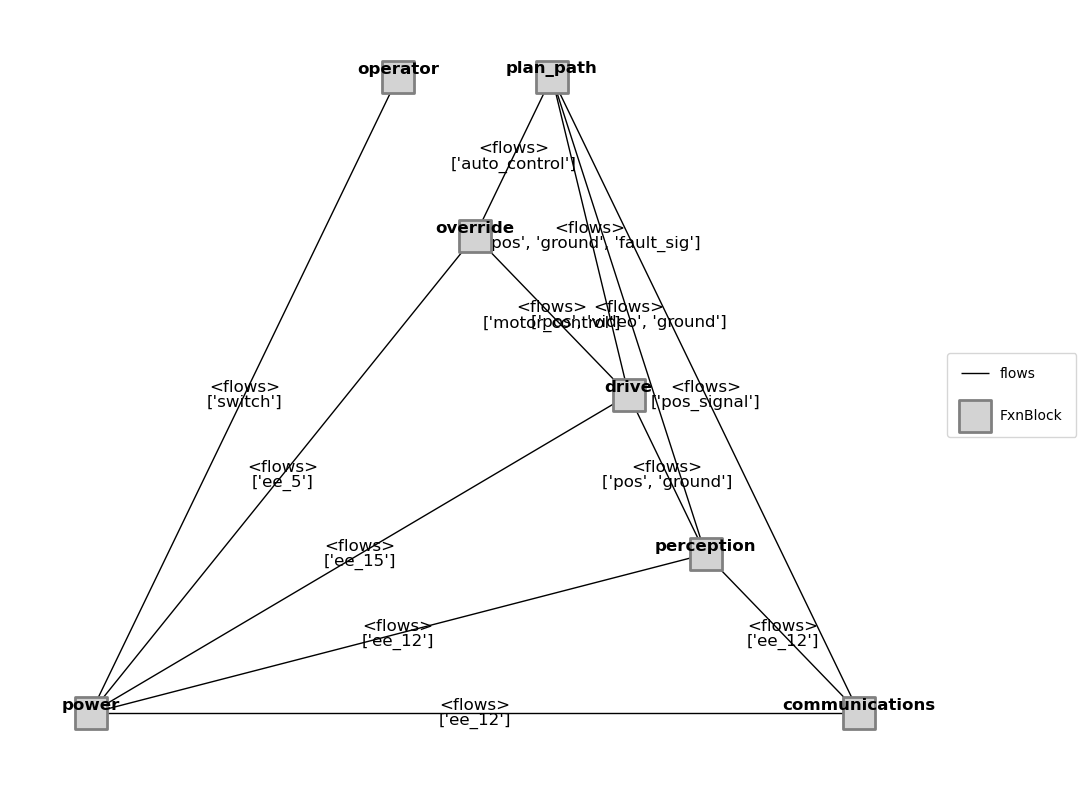

In [17]:
mg = an.graph.ModelFxnGraph(mdl)
fig, ax = mg.draw()

The functions are:
- `Operator`, the operator of the rover who turns it on/off and takes control if needed (not fully implemented)
- `Power`, the battery and power supply
- `Communications`, the radio used to relay back position/etc. to the operator
- `Avionics`, the computer/control system which determines where to direct the given position information
- `Override`, the system that enables the operator to control the rover instead
- `Perception`, the camera/AI system which percieves the ground and then (not fully implemented)
- `Environment`, which defines the lines and/or changes to the environment based on environmental conditions and/or the movement of the system

The flows are:
- `Control`, the physical interactions between the operator and the rover (i.e. on/off)
- `Comms`, the communications between the operator and the rover (position, video, etc.)
- `OverrideComms`, the communications between the operator and the 
- `Pos_Signal`, the rover's internal idea of its position and velocity
- `EE5`, `EE12`, `EE15`, the electrical power provided by the  battery
- `AvionicsControl`, the contol signals from the avionics to the drive system
- `Video`, the video feed/signal from the camera to the avionics
- `MotorControl`, the control signals to the drive system(s)
- `Ground`, the real position of the rover and the ground/environment/etc.

The model is presently a mixed static/dynamic propagation model in which most function behaviors propagate over time, except for the power system, which propagates in a dynamic step. This may change depending on the necessity to model interactions between these systems. This is shown below.

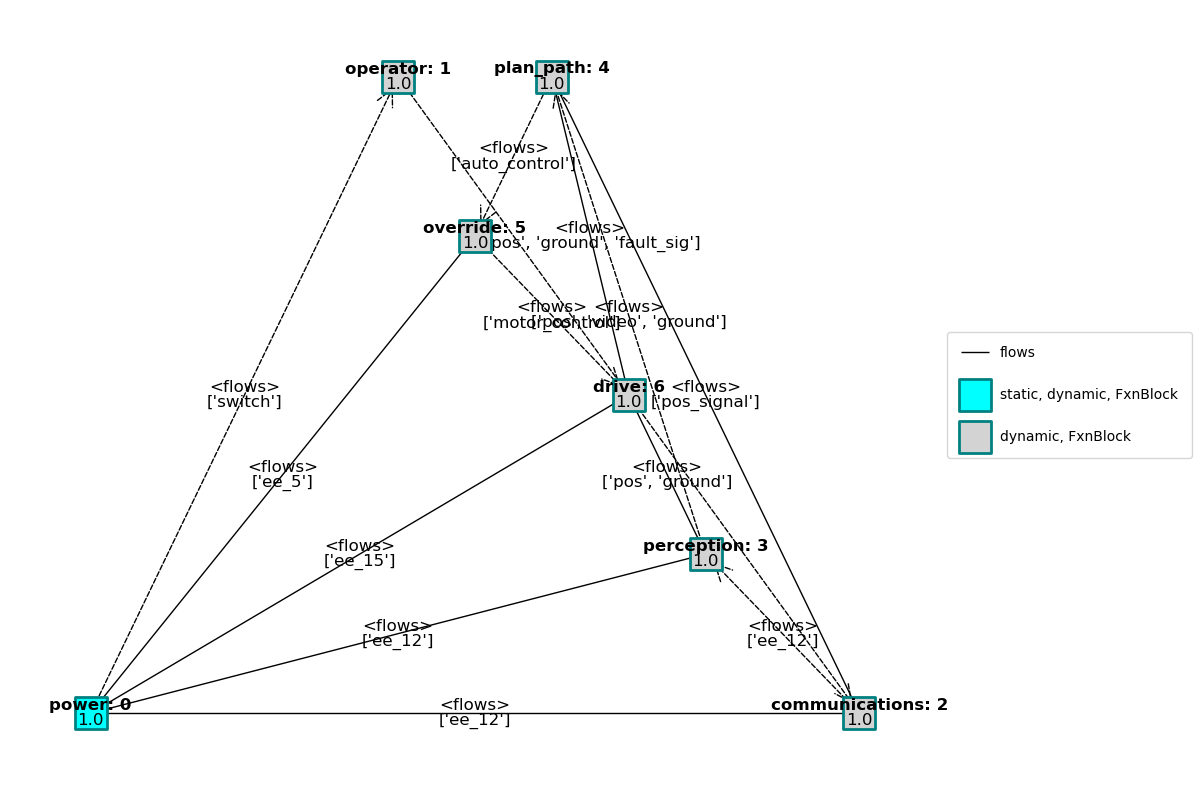

In [18]:
mg.set_exec_order(mdl)
fig, ax = mg.draw()

The run order for this model is additionally shown below.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

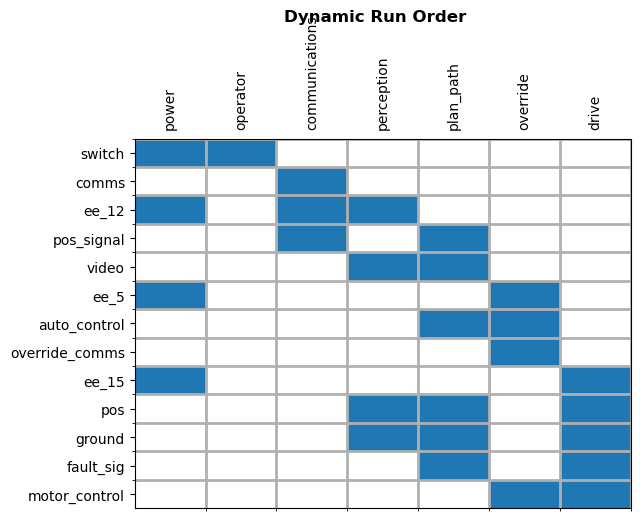

In [19]:
an.plot.dyn_order(mdl, rotateticks=True)

## Model simulation

Currently, the model can be simulated in a few situations for lane-tracking: a sine wave and a 90-degree turn.

Below shows the 90-degree turn. As shown, the centerline tracking is not perfect, with a fairly large deviation in distance (current limit for viewing the line in the model is 1 meter). This should be controlled in the future by lowering the timestep (enabling more corrections) or enabling some reduction to velocity when going around corners.

(<Figure size 400x400 with 1 Axes>, <Axes: >)

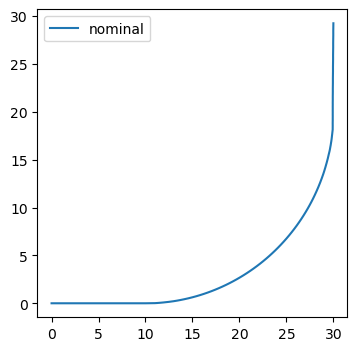

In [20]:
mdl = Rover(p=RoverParam(ground = GroundParam(linetype='turn')))
endresults, mdlhist = prop.nominal(mdl)
an.show.trajectories(mdlhist, 'pos.s.x', 'pos.s.y')

In [21]:
mdlhist['time']

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117.])

Below shows the sine wave. As shown, this curve has a relatively low amplitude (see the y-axis), which results in low tracking error.

(<Figure size 400x400 with 1 Axes>, <Axes: >)

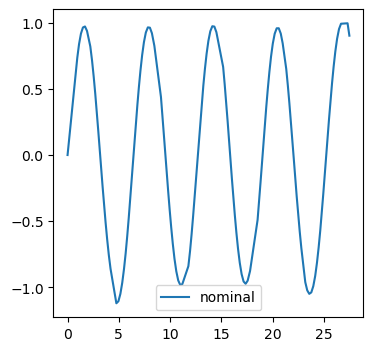

In [24]:
mdl = Rover(p=RoverParam(ground = GroundParam(linetype='sine')))
endresults, mdlhist = prop.nominal(mdl)
an.show.trajectories(mdlhist, 'pos.s.x', 'pos.s.y')

In [ ]:
mdlhist['time']

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40.])

The performance of the rover in these situations is dependent on the parameters of the situation (e.g., the radius of the curve and the amplitude of the sine wave). Thus, it is important to define the operational envelope for the system. This can be done using a `NominalApproach`, which can be used to define ranges of variables to simulate the system under.

In [ ]:
from fmdtools.sim.approach import NominalApproach

In this approach we define parameter ranges for the two major situations--a wavelength and amplitude for the sine wave, and a radius and start location for the turn.

In [ ]:
app = NominalApproach()
app.add_param_ranges(RoverParam,'sine', 'sine', amp=(0, 8, 0.2), wavelength=(10.0,50,10))
app.add_param_ranges(RoverParam,'turn','turn', radius=(5,40,5.0), start=(0, 20.0,5))

In [ ]:
app

NominalApproach (188 scenarios) with ranges:
-sine (160 scenarios)
----fixedargs: ('sine',)
----fixedkwargs: {}
----inputranges: {'amp': (0, 8, 0.2), 'wavelength': (10.0, 50, 10)}
----replicates: 1
----paramfunc: <class 'rover_model.RoverParam'>
-turn (28 scenarios)
----fixedargs: ('turn',)
----fixedkwargs: {}
----inputranges: {'radius': (5, 40, 5.0), 'start': (0, 20.0, 5)}
----replicates: 1
----paramfunc: <class 'rover_model.RoverParam'>

This approach can then be run using `prop.nominal_approach`

In [ ]:
endclasses, mdlhists= prop.nominal_approach(mdl, app, pool = mp.Pool(5))


SCENARIOS COMPLETE:   0%|          | 0/188 [00:00<?, ?it/s]


SCENARIOS COMPLETE: 100%|██████████| 188/188 [00:00<?, ?it/s]

We can then use these results to visualize the operational envelope for the system--which sets of parameters lead to the system getting lost/going off track, and which sets of parameters the system is capable of accomodating.

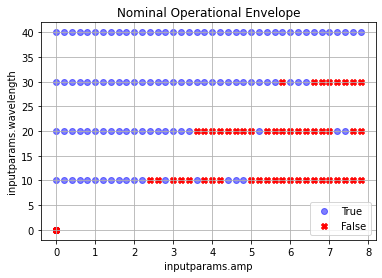

In [ ]:
fig = an.plot.nominal_vals_2d(app, endclasses, 'inputparams.amp', 'inputparams.wavelength', nom_func=lambda x: x == True, metric='at_finish')

As shown, if the amplitude of the sine curve is too high at low wavelength, it causes the rover to go off track and not be able to complete the mission.

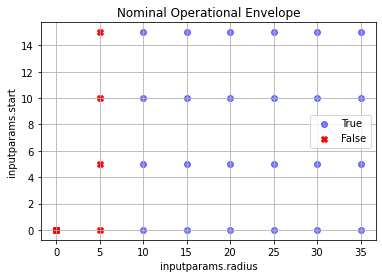

In [ ]:
fig = an.plot.nominal_vals_2d(app, endclasses, 'inputparams.radius', 'inputparams.start', nom_func=lambda x: x == True, metric='at_finish')

Similarly, if the radius of the curve is too small, it can additionally lead to the rover going off course by overshooting the curve.

AttributeError: 'numpy.ndarray' object has no attribute 'flows'

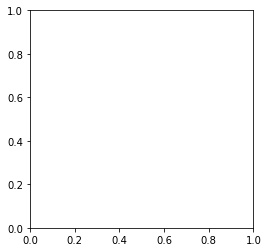

In [ ]:
fig = plot_trajectories(mdlhists.get_scens(*app.ranges['sine']['scenarios']))

In [ ]:
fig = plot_trajectories(mdlhists.get_scens(*app.ranges['turn']['scenarios']))